In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-6ozxx2pg
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-6ozxx2pg
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=c035fbc48f5c23a5d7936de4bb68c717bcbbb28c5082edce2040190eee73b2de
  Stored in directory: /tmp/pip-ephem-wheel-cache-pfmuab00/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!find .. -name 'libopencv*'

In [ ]:
!pkg-config --cflags --libs opencv

-I/usr/include/opencv -lopencv_shape -lopencv_stitching -lopencv_superres -lopencv_videostab -lopencv_aruco -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_datasets -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_line_descriptor -lopencv_optflow -lopencv_video -lopencv_plot -lopencv_reg -lopencv_saliency -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_rgbd -lopencv_viz -lopencv_surface_matching -lopencv_text -lopencv_ximgproc -lopencv_calib3d -lopencv_features2d -lopencv_flann -lopencv_xobjdetect -lopencv_objdetect -lopencv_ml -lopencv_xphoto -lopencv_highgui -lopencv_videoio -lopencv_imgcodecs -lopencv_photo -lopencv_imgproc -lopencv_core


In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [ ]:
# %%cuda --name my_curand.cu 
# /*
#  * This program uses the host CURAND API to generate 100 
#  * pseudorandom floats.
#  */
# #include <stdio.h>
# #include <stdlib.h>
# #include <cuda.h>
# #include <curand.h>

# #define CUDA_CALL(x) do { if((x)!=cudaSuccess) { \
#     printf("Error at %s:%d\n",__FILE__,__LINE__);\
#     return EXIT_FAILURE;}} while(0)
# #define CURAND_CALL(x) do { if((x)!=CURAND_STATUS_SUCCESS) { \
#     printf("Error at %s:%d\n",__FILE__,__LINE__);\
#     return EXIT_FAILURE;}} while(0)

# int main(int argc, char *argv[])
# {
#     size_t n = 100;
#     size_t i;
#     curandGenerator_t gen;
#     float *devData, *hostData;

#     /* Allocate n floats on host */
#     hostData = (float *)calloc(n, sizeof(float));

#     /* Allocate n floats on device */
#     CUDA_CALL(cudaMalloc((void **)&devData, n*sizeof(float)));

#     /* Create pseudo-random number generator */
#     CURAND_CALL(curandCreateGenerator(&gen, 
#                 CURAND_RNG_PSEUDO_DEFAULT));

#     /* Set seed */
#     CURAND_CALL(curandSetPseudoRandomGeneratorSeed(gen, 
#                 1234ULL));

#     /* Generate n floats on device */
#     CURAND_CALL(curandGenerateUniform(gen, devData, n));

#     /* Copy device memory to host */
#     CUDA_CALL(cudaMemcpy(hostData, devData, n * sizeof(float),
#         cudaMemcpyDeviceToHost));

#     /* Show result */
#     for(i = 0; i < n; i++) {
#         printf("%1.4f ", hostData[i]);
#     }
#     printf("\n");

#     /* Cleanup */
#     CURAND_CALL(curandDestroyGenerator(gen));
#     CUDA_CALL(cudaFree(devData));
#     free(hostData);    
#     return EXIT_SUCCESS;
# }

'File written in /content/src/my_curand.cu'

In [ ]:
# !nvcc -o /content/src/my_curand /content/src/my_curand.cu -lcurand

gcc: error: /content/src/my_curand.cu: No such file or directory
gcc: warning: ‘-x c++’ after last input file has no effect
gcc: fatal error: no input files
compilation terminated.


In [ ]:
# !/content/src/my_curand

/bin/bash: /content/src/my_curand: No such file or directory


## Còdigo  rgb to grey

In [ ]:
%%cuda --name rgbtogrey.cu

#include <stdio.h>
#include <string>
#include <math.h>
#include <iostream>
#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <opencv2/imgproc/imgproc.hpp>
#define CHANNELS 3

__global__
void colorToGreyscaleConversion( unsigned char *Pout, unsigned char * Pin, int height, int width) {
  
  int Col = threadIdx.x + blockIdx.x * blockDim.x;
  int Row = threadIdx.y + blockIdx.y * blockDim.y;

  if (Col < width && Row < height) {

    int greyOffset = Row*width + Col;

    int rgbOffset = greyOffset*CHANNELS;
    unsigned char r = Pin[rgbOffset + 0];
    unsigned char g = Pin[rgbOffset + 1];
    unsigned char b = Pin[rgbOffset + 2]; 

    Pout[greyOffset] = 0.21f*r + 0.71f*g + 0.07f*b;
  }
}


int main(int argc, char **argv) 
{
	std::string input_file;
	std::string output_file;


	switch(argc) {
		case 3:
			input_file = std::string(argv[1]);
			output_file = std::string(argv[2]);
            break;
		default:
			std::cerr << "Usage: <executable> input_file output_file";
			exit(1);
	}
	
	unsigned char *d_rgb_image, *h_rgb_image;
	unsigned char *h_grey_image, *d_grey_image; 
	int rows; 
	int cols; 
	
  cv::Mat img_data;	
	img_data = cv::imread(input_file.c_str(), CV_LOAD_IMAGE_COLOR);
 
  rows = img_data.rows;
	cols = img_data.cols;

	h_rgb_image = (unsigned char*)img_data.data;
 
  //int i = 0;
  //for (i = 0; i < rows * cols * 3; i++)
  // {
   // std::cout<<h_rgb_image[i]<<" ";
  //}
    
 
	size_t total_pixels = img_data.rows * img_data.cols; 
	
	h_grey_image = (unsigned char *)malloc(sizeof(unsigned char*)* total_pixels);

	
	cudaMalloc(&d_rgb_image, sizeof(unsigned char) * total_pixels * CHANNELS);
	cudaMalloc(&d_grey_image, sizeof(unsigned char) * total_pixels);
	
	cudaMemcpy(d_rgb_image, h_rgb_image, sizeof(unsigned char) * total_pixels * CHANNELS, cudaMemcpyHostToDevice);

	
	const dim3 dimGrid((int)ceil((cols)/16), (int)ceil((rows)/16));
	const dim3 dimBlock(16, 16);
	
	
	colorToGreyscaleConversion<<<dimGrid, dimBlock>>>(d_grey_image,d_rgb_image, rows, cols);

	
	cudaMemcpy(h_grey_image, d_grey_image, sizeof(unsigned char) * total_pixels, cudaMemcpyDeviceToHost);
 
  cv::Mat greyData(rows, cols, CV_8UC1,(void *) h_grey_image);
    
  cv::imwrite(output_file.c_str(), greyData);

	cudaFree(d_rgb_image);
	cudaFree(d_grey_image);
	return 0;
}

'File written in /content/src/rgbtogrey.cu'

In [ ]:
!nvcc -o /content/src/rgbtogrey /content/src/rgbtogrey.cu -lcurand -L/path/to/my/openCV/lib -lopencv_core -lopencv_imgcodecs

In [ ]:
!/content/src/rgbtogrey /content/test.jpg /content/imgResultante.jpg

In [ ]:
import cv2
from matplotlib import pyplot as plt

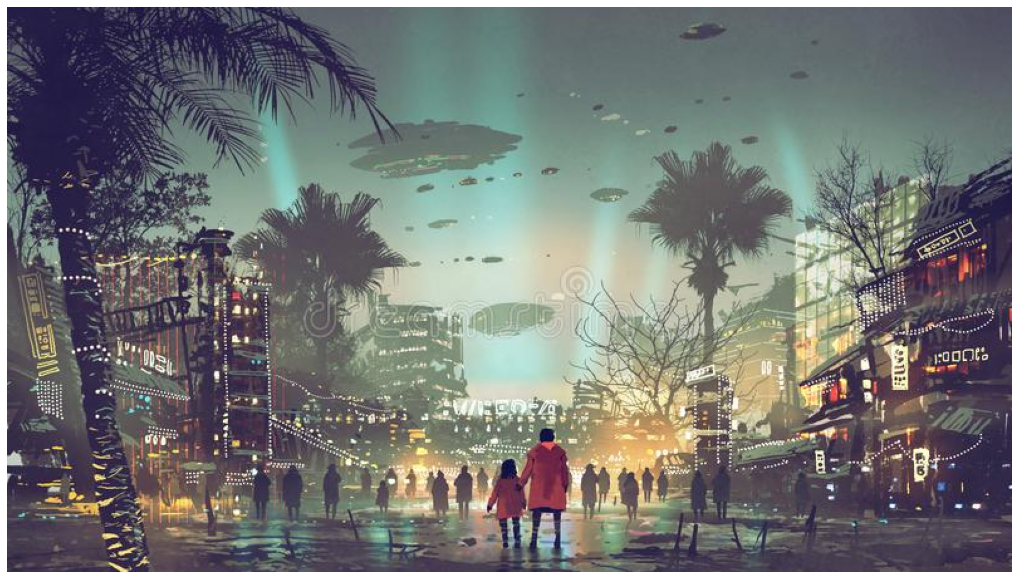

In [ ]:
img_color = cv2.imread('test.jpg',1)

fig = plt.figure(figsize=(18, 18))
plt.axis("off")
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()

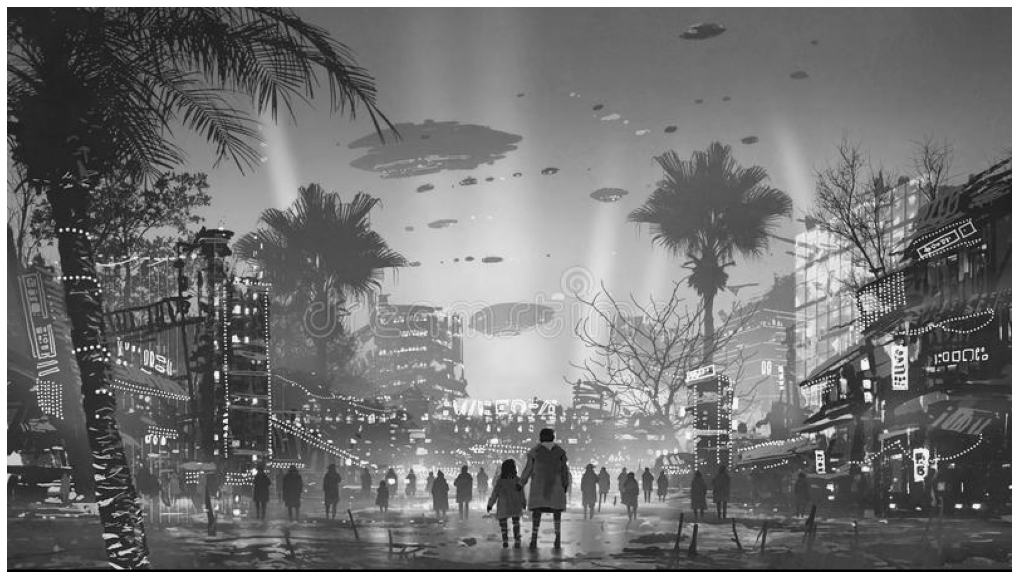

In [ ]:
img_color = cv2.imread('imgResultante.jpg',1)

fig = plt.figure(figsize=(18, 18))
plt.axis("off")
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()

## Código image blur

In [ ]:
%%cuda --name rgbtoblur.cu

#include <stdio.h>
#include <string>
#include <math.h>
#include <iostream>
#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <opencv2/imgproc/imgproc.hpp>
#define BLUR_SIZE 3
#define CHANNELS 3

__global__
void blurKernel( unsigned char *Pin, unsigned char * Pout, int width, int height) {
  
  int Col = blockIdx.x * blockDim.x + threadIdx.x;
  int Row =  blockIdx.y * blockDim.y + threadIdx.y;

  if (Col < width && Row < height) {
    int pixVal1 = 0;
    int pixVal2 = 0;
    int pixVal3 = 0;
    int pixels = 0;


    for(int blurRow= -BLUR_SIZE ; blurRow<BLUR_SIZE + 1; ++blurRow){
        for(int blurCol= -BLUR_SIZE ; blurCol<BLUR_SIZE + 1; ++blurCol){
            int curRow = Row + blurRow;
            int curCol = Col + blurCol;
            if(curRow>-1 && curRow<height && curCol>-1 && curCol<width){
                pixVal1 += Pin[(curRow * width + curCol)*CHANNELS + 0];
                pixVal2 += Pin[(curRow * width + curCol)*CHANNELS + 1];
                pixVal3 += Pin[(curRow * width + curCol)*CHANNELS + 2];
                pixels++;
            }
        }
    }
    Pout[(Row * width + Col) * CHANNELS + 0] = (unsigned char)(pixVal1/pixels);
    Pout[(Row * width + Col) * CHANNELS + 1] = (unsigned char)(pixVal2/pixels);
    Pout[(Row * width + Col) * CHANNELS + 2] = (unsigned char)(pixVal3/pixels);
  }
}


int main(int argc, char **argv) 
{
	std::string input_file;
	std::string output_file;


	switch(argc) {
		case 3:
			input_file = std::string(argv[1]);
			output_file = std::string(argv[2]);
            break;
		default:
			std::cerr << "Usage: <executable> input_file output_file";
			exit(1);
	}
	
	unsigned char *d_rgb_image, *h_rgb_image;
	unsigned char *h_blur_image, *d_blur_image; 
	int rows; 
	int cols; 
	
  cv::Mat img_data;	
	img_data = cv::imread(input_file.c_str(), CV_LOAD_IMAGE_COLOR);
 
  rows = img_data.rows;
	cols = img_data.cols;

	h_rgb_image = (unsigned char*)img_data.data;
 
  //int i = 0;
  //for (i = 0; i < rows * cols * 3; i++)
  // {
   // std::cout<<h_rgb_image[i]<<" ";
  //}
    
 
	size_t total_pixels = img_data.rows * img_data.cols; 
	
	h_blur_image = (unsigned char *)malloc(sizeof(unsigned char*)* total_pixels * CHANNELS);

	
	cudaMalloc(&d_rgb_image, sizeof(unsigned char) * total_pixels * CHANNELS);
	cudaMalloc(&d_blur_image, sizeof(unsigned char) * total_pixels * CHANNELS);
	
	cudaMemcpy(d_rgb_image, h_rgb_image, sizeof(unsigned char) * total_pixels * CHANNELS, cudaMemcpyHostToDevice);

	
	const dim3 dimGrid((int)ceil((cols)/16), (int)ceil((rows)/16));
	const dim3 dimBlock(16, 16);
	
	
	blurKernel<<<dimGrid, dimBlock>>>(d_rgb_image,d_blur_image, cols, rows);

	
	cudaMemcpy(h_blur_image, d_blur_image, sizeof(unsigned char) * total_pixels * CHANNELS, cudaMemcpyDeviceToHost);
 
  cv::Mat rgbData(rows, cols, CV_8UC3,(void *) h_blur_image);
    
  cv::imwrite(output_file.c_str(), rgbData);

	cudaFree(d_rgb_image);
	cudaFree(d_blur_image);
	return 0;
}

'File written in /content/src/rgbtoblur.cu'

In [ ]:
!nvcc -o /content/src/rgbtoblur /content/src/rgbtoblur.cu -lcurand -L/path/to/my/openCV/lib -lopencv_core -lopencv_imgcodecs

In [ ]:
!/content/src/rgbtoblur /content/lena.jpg /content/imgblur.jpg

In [ ]:
import cv2
from matplotlib import pyplot as plt

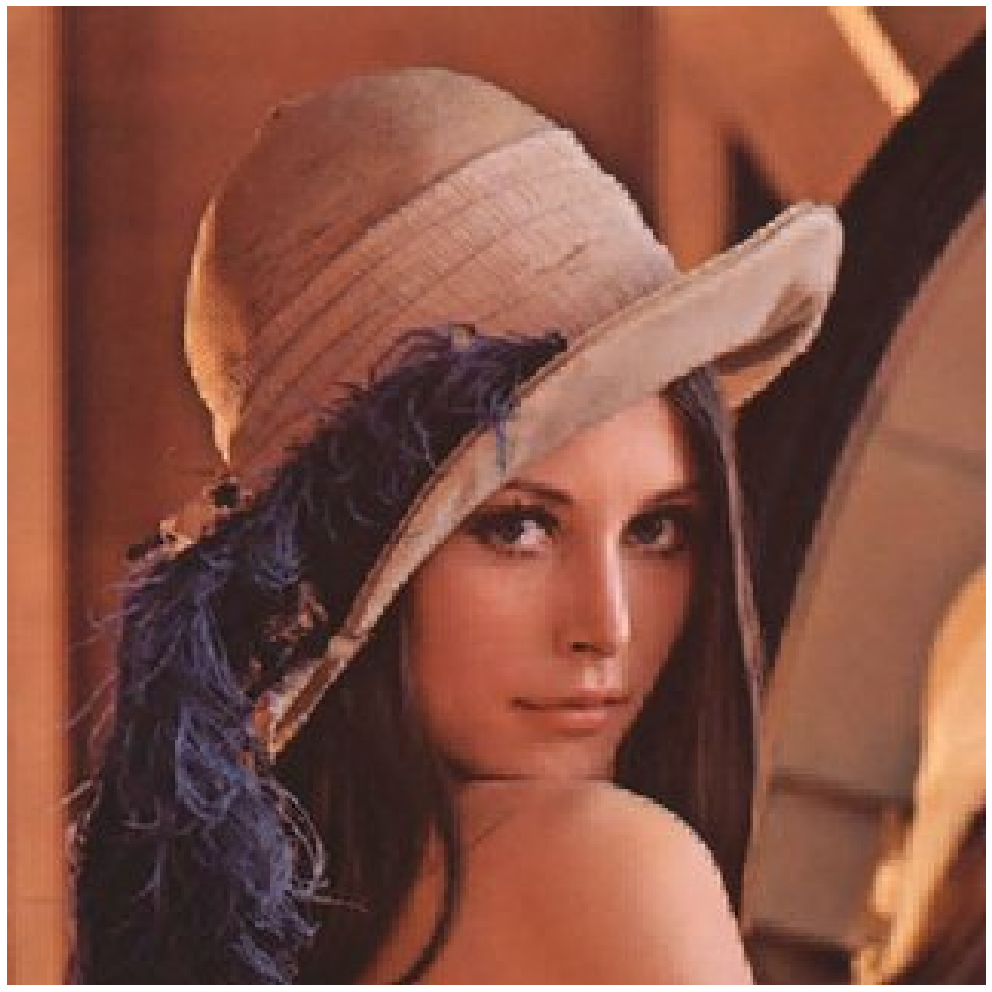

In [ ]:
img_color = cv2.imread('lena.jpg',1)

fig = plt.figure(figsize=(18, 18))
plt.axis("off")
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()


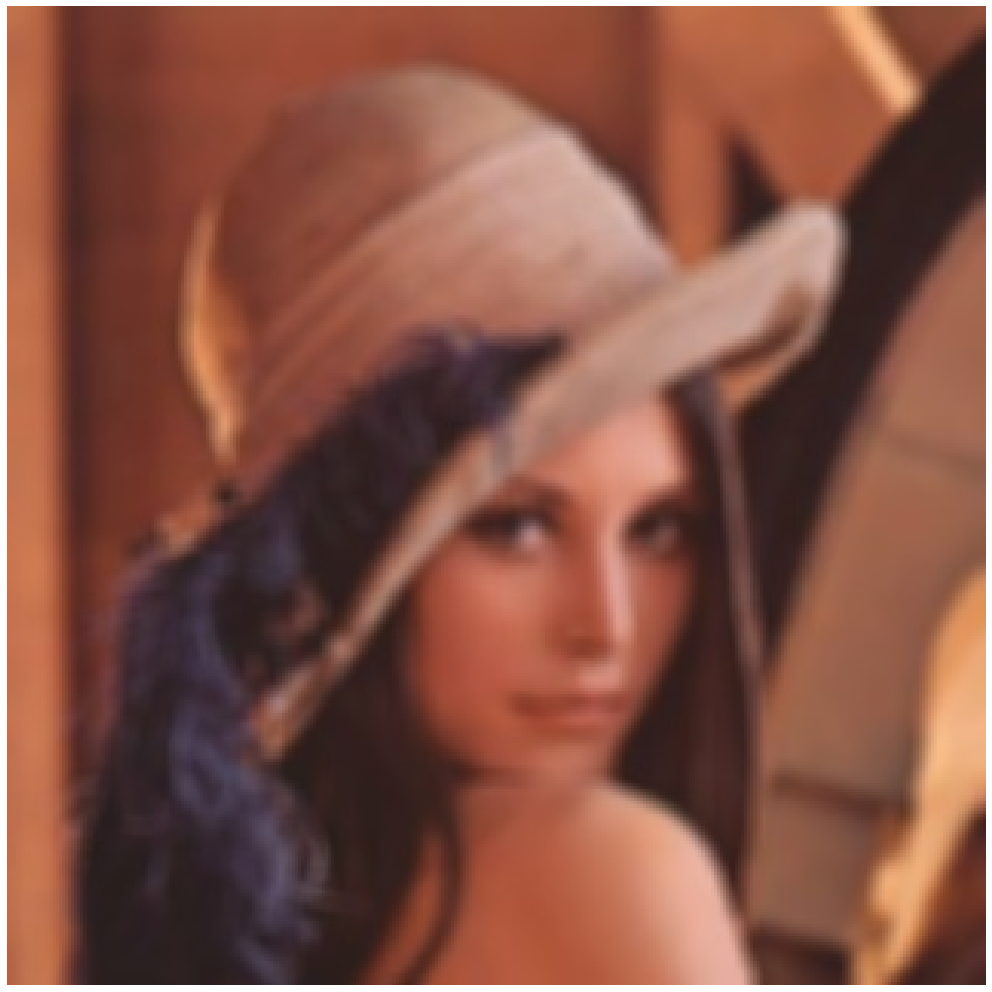

In [ ]:
img_color = cv2.imread('imgblur.jpg',1)

fig = plt.figure(figsize=(18, 18))
plt.axis("off")
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()